In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pandas as pd
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

def diversification_ratio(w, sigma, cov):
    numerator = np.dot(w, sigma)
    denominator = np.sqrt(np.dot(w.T, np.dot(cov, w)))
    return numerator / denominator if denominator != 0 else 0

def optimize_mdpp_hybrid(mu, sigma, cov, lambda1=0.5, lambda2=0.3):

    n = len(mu)
    w0 = np.ones(n) / n
    bounds = [(0, 1)] * n
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

    def objective(w):
        dr = diversification_ratio(w, sigma, cov)
        expected_return = np.dot(mu, w)
        risk_penalty = np.dot(w.T, np.dot(cov, w))
        return -(dr + lambda1 * expected_return - lambda2 * risk_penalty)

    result = minimize(objective, w0, bounds=bounds, constraints=constraints, method='SLSQP')
    return result.x if result.success else w0

def rolling_test_mdpp_hybrid(
    df, 
    start_test, 
    end_test, 
    window_size=60, 
    lambda1=0.5, 
    lambda2=0.3, 
    initial_capital=1.0, 
    trading_cost=0.001, 
    rebalance_freq=5
):
    df = df.copy()
    df = df.loc[start_test:end_test]
    test_dates = df.index
    n_assets = df.shape[1]

    capital = initial_capital
    w_prev = np.ones(n_assets) / n_assets
    weights_history = pd.DataFrame(index=test_dates, columns=df.columns)
    portfolio_value = pd.Series(index=test_dates, dtype=float)

    for i, current_date in enumerate(test_dates):
        if i < window_size:
            if i > 0:
                prices_today = df.iloc[i].values
                prices_yesterday = df.iloc[i - 1].values
                daily_return = np.dot(w_prev, prices_today / prices_yesterday - 1)
                capital *= (1 + daily_return)
            portfolio_value[current_date] = capital
            weights_history.loc[current_date] = w_prev
            continue

        if i % rebalance_freq == 0:
            window_data = df.iloc[i - window_size:i]
            returns = window_data.pct_change().dropna()
            mu = returns.mean().values
            sigma = returns.std().values
            cov = returns.cov().values

            w_opt = optimize_mdpp_hybrid(mu, sigma, cov, lambda1, lambda2)
            turnover = np.sum(np.abs(w_opt - w_prev))
            cost = turnover * trading_cost * capital
            capital -= cost
        else:
            w_opt = w_prev

        prices_today = df.iloc[i].values
        prices_yesterday = df.iloc[i - 1].values
        gross_return = np.dot(w_prev, prices_today / prices_yesterday - 1)
        capital *= (1 + gross_return)

        portfolio_value[current_date] = capital
        weights_history.loc[current_date] = w_opt
        w_prev = w_opt.copy()

    return portfolio_value, weights_history


In [ ]:


def load_data(base_dir, sample_n=50):
    all_data = []
    tickers_seen = set()
    for root, _, files in os.walk(base_dir):
        np.random.shuffle(files)
        for file in files:
            if file.endswith(".csv"):
                path = os.path.join(root, file)
                try:
                    ticker = os.path.splitext(file)[0]
                    if ticker in tickers_seen:
                        continue
                    df = pd.read_csv(path, skiprows=2, header=None,
                                     names=["Date", "Close", "High", "Low", "Open", "Volume"],
                                     usecols=["Date", "Close"])
                    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
                    df = df.dropna(subset=["Date", "Close"])
                    if df.shape[0] > 100:
                        df["TICKER"] = ticker
                        all_data.append(df)
                        tickers_seen.add(ticker)
                        if len(tickers_seen) >= sample_n:
                            break
                except Exception:
                    continue
        if len(tickers_seen) >= sample_n:
            break
    if not all_data:
        raise Exception("Brak danych")
    return pd.concat(all_data, ignore_index=True)

def prepare_pivot(df, start_year=2020, end_year=2025, max_nan_percent=5.0):
    df = df[(df["Date"].dt.year >= start_year) & (df["Date"].dt.year <= end_year)]
    pivot = df.pivot(index="Date", columns="TICKER", values="Close").sort_index()
    pivot = pivot[pivot.index.weekday < 5]
    nans = pivot.isna().sum() / len(pivot) * 100
    good_tickers = nans[nans <= max_nan_percent].index.tolist()
    pivot = pivot[good_tickers].fillna(method="ffill").fillna(method="bfill")
    return pivot


In [3]:
base_dir = r"C:\Users\Basia\Do przejrzenia\am_sem2\mgr\kody\downloaded_data"

df_all = load_data(base_dir, sample_n=777)
pivot_df = prepare_pivot(df_all)

C:\Users\Basia\AppData\Local\Temp\ipykernel_5676\958827702.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot = pivot[good_tickers].fillna(method="ffill").fillna(method="bfill")


In [ ]:

start_date = "2025-01-01"
end_date = "2025-03-31"
window = 60
lambda1_val = 0.8
lambda2_val = 0.3
init_capital = 1.0
trading_cost_val = 0.001
rebalance_every = 5


capital_series, weight_series = rolling_test_mdpp_hybrid(
    df=pivot_df,
    start_test=start_date,
    end_test=end_date,
    window_size=window,
    lambda1=lambda1_val,
    lambda2=lambda2_val,
    initial_capital=init_capital,
    trading_cost=trading_cost_val,
    rebalance_freq=rebalance_every
)



<Axes: title={'center': 'Kapitał portfela w czasie'}, xlabel='Date'>

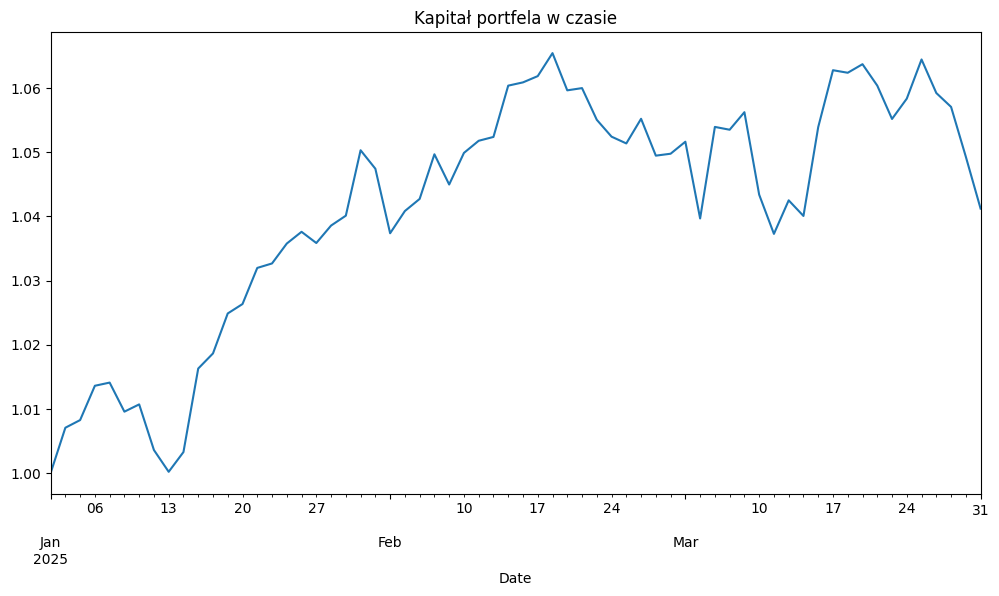

In [ ]:
capital_series.plot(title="Kapitał portfela w czasie", figsize=(12, 6))
print("Ostateczny kapitał:", capital_series.iloc[-1])